In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense
from keras.models import Sequential
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
#Exploratory Analysis
data=pd.read_csv('RB_stats.csv')

#Gets the dimensions of the data frame. 558 rows by 32 columns
data.shape

data.head()

#Drops the Player name, Year, and team columns will not need them for scaling
preprocess_data=data.iloc[:,3:33]
preprocess_data=preprocess_data.dropna()




In [3]:
data.describe()

,Year,Age,GP,RB_1,%Snaps,#Snaps,Total_Touches,Rush_Att,Rush_Yds,Yards/Att,...,Fantasy_Point,FF_PPG,P/Snap,100+Yrd/games,Games_w/TD,18+_Touch,Top_12,Perfromance_Metric,Points/Touch,Point/Touch-TD
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,...,558.000000,558.000000,557.000000,558.000000,557.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,2017.050179,25.474910,12.037634,0.129032,0.296308,317.084229,128.491039,105.032258,443.713262,3.966846,...,97.774194,7.610394,0.298187,1.888889,3.140036,2.460573,2.159498,11.884229,0.793441,0.304409
std,1.551391,2.915676,4.401365,0.335536,0.207881,222.395813,97.852575,85.807950,381.132702,1.268933,...,77.654702,5.233211,0.156968,2.638314,2.806428,3.462710,2.776797,14.171099,0.367227,0.293249
min,2014.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-3.000000,-2.000000,...,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,23.000000,10.000000,0.000000,0.130000,146.250000,46.000000,33.250000,122.750000,3.500000,...,35.075000,3.700000,0.240000,0.000000,1.000000,0.000000,0.000000,2.200000,0.610000,0.132500
50%,2017.000000,25.000000,14.000000,0.000000,0.265000,290.500000,108.500000,83.000000,343.500000,4.000000,...,80.350000,7.050000,0.290000,1.000000,3.000000,1.000000,1.000000,6.750000,0.730000,0.170000
75%,2018.000000,27.000000,16.000000,0.000000,0.440000,470.750000,199.750000,167.750000,705.500000,4.600000,...,143.775000,10.775000,0.350000,3.000000,5.000000,4.000000,3.000000,16.075000,0.897500,0.410000
max,2019.000000,36.000000,16.000000,1.000000,0.930000,1056.000000,449.000000,392.000000,1845.000000,11.300000,...,411.200000,40.600000,1.970000,15.000000,13.000000,16.000000,14.000000,87.300000,4.650000,3.700000


In [5]:
#Scale the data to be able to run models correctly without any weight bias
data_scale=preprocessing.scale(preprocess_data)
data_scale=pd.DataFrame(data_scale)

#Scaling the data causes the data to trasnform into a numpy array, I want it as a data frame to perform a correlation matrix.
#But the new data frame does not contain the labels. So I will need to add the labels.

#Creates an empty list to store the column names
col_names=[]
#For loop that stores column names
for col in preprocess_data:
    col_names.append(col)
#adss the column names to the scaled data
data_scale.columns=col_names

#Creates the correlation matrix
corr_matrix=data_scale.corr()
#Fantasy Point correlation
fantasy_point_corr=corr_matrix['Fantasy_Point'].sort_values(ascending=False)
#Correlation for Running Back 1 for each labels
corr_matrix['RB_1'].sort_values(ascending=False)


RB_1                  1.000000
Perfromance_Metric    0.774779
Top_12                0.767868
100+Yrd/games         0.748242
Fantasy_Point         0.721134
18+_Touch             0.711938
Total_TD              0.692962
Rush_Yds              0.659337
Total_Touches         0.650792
Rush_TD               0.650743
Games_w/TD            0.633498
FF_PPG                0.631735
%Snaps                0.624737
#Snaps                0.623976
Rush_Att              0.619246
Receiving_Yards       0.528276
Target                0.518204
Reception             0.515433
Target_Share_%        0.468137
Rec_TD                0.414060
Fumbles               0.288318
GP                    0.269234
Yards/Att             0.167964
P/Snap                0.164275
Yards/Rec             0.062041
Points/Touch          0.049752
Touch/TD             -0.010386
Age                  -0.070279
Point/Touch-TD       -0.091435
Name: RB_1, dtype: float64

In [6]:

#Creates target Variable
Y=preprocess_data.iloc[:,2]
#Creates indepent Variables
X=data_scale.drop('RB_1', axis=1)
#create feature list
feature_list=list(X.columns)

#Split data set into training and test Sets
x_train,X_test,y_train,Y_test=train_test_split(X,Y, test_size=.3,random_state=42)

len(feature_list)



28

In [11]:
#Run Logistic Regression model and predictions
log_reg=LogisticRegression()
model=log_reg.fit(x_train,y_train)
predict=model.predict(X_test)

In [9]:
import itertools
import matplotlib.pyplot as plt

#Plot feautres of the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis-1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion Matrix w/o Normalization')
    print(cm)
    #Creates threshold to determine font color and labels each section of confusion matrix with their number 
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalaligment='center',
        color='white'if cm[i,j]>thresh else 'black'
    
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
cm_plot_labels=['Not RB1','RB1']

Confusion Matrix w/o Normalization
[[140   3]
 [  2  22]]


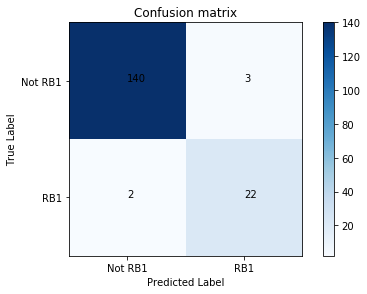

In [13]:
#Pots confusion matrix
cm=confusion_matrix(Y_test,predict)

cm_plot_labels=['Not RB1','RB1']
plot_confusion_matrix(cm, cm_plot_labels)



In [14]:
print('Precision Score for Logestic Regression is',precision_score(Y_test,predict))
print('Recall Score for Logestic Regression is:',recall_score(Y_test,predict))
print('Accuracy Socre Logestic Regression is :', accuracy_score(Y_test,predict))

Precision Score for Logestic Regression is 0.88
Recall Score for Logestic Regression is: 0.9166666666666666
Accuracy Socre Logestic Regression is : 0.9700598802395209


In [15]:
#Creates cross validation score from Logistic Model
from sklearn.model_selection import cross_val_score,cross_val_predict
cv=cross_val_score(log_reg, x_train,y_train, cv=5, scoring='accuracy')
cv.mean()

0.964002664002664

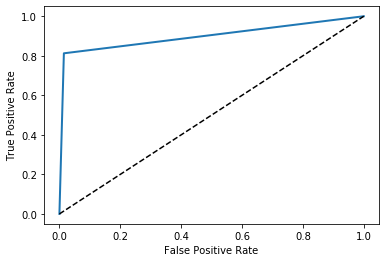

In [16]:
#Plot ROC Curve
from sklearn.metrics import roc_curve
y_scores=cross_val_predict(log_reg,x_train,y_train,cv=5)

fpr,tpr,thresholds=roc_curve(y_train,y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
    

In [5]:
#Start the Random Forest Machine Learning.

random.seed(42)

#Set up Random Forest
n_estimators=[10,20,30,40,50,60,70,80,90,100]
random_forest=RandomForestClassifier()

#Set up parameters to perform Grid Search. Use random forest function, the parameters, cross vaildation of 10
#and measures scoring by accuracy 
param_grid=dict(n_estimators=n_estimators)
grid=GridSearchCV(random_forest,param_grid, cv=10, scoring='accuracy') 

#Fit the grid with the data
grid.fit(x_train,y_train)
    



GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [6]:
#Get mean validation scores for each n_estimator
grid.cv_results_['mean_test_score']


array([0.96396761, 0.96916329, 0.96916329, 0.96659919, 0.96916329,
       0.96916329, 0.96659919, 0.9717274 , 0.96916329, 0.9717274 ])

In [7]:
#Retreieve optimal information to achieve best model
print(grid.best_params_)
print(grid.best_score_)
print (grid.best_estimator_)

{'n_estimators': 80}
0.9717273954116058
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


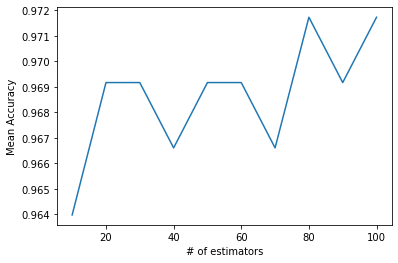

In [10]:
#plot cross validation Results
plt.plot(n_estimators,grid.cv_results_['mean_test_score'])
plt.xlabel('# of estimators')
plt.ylabel('Mean Accuracy')
plt.show()

Confusion Matrix w/o Normalization
[[141   2]
 [  2  22]]


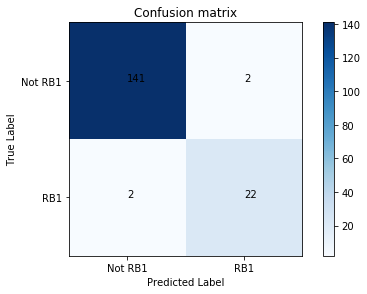

In [11]:
#Creates the model with the best hyperparamter 
final_model=grid.best_estimator_
#Predicts the model
final_prediction=final_model.predict(X_test)
#Creates the confusion matrix
forest_cm=confusion_matrix(Y_test,final_prediction)
#Plots the confusion matrix
plot_confusion_matrix(forest_cm, cm_plot_labels)

In [12]:
print('Precision Score for Random Forest is',precision_score(Y_test,final_prediction))
print('Recall Score for Random Forest is:',recall_score(Y_test,final_prediction))
print('Accuracy Socre Random Forest is :', accuracy_score(Y_test,final_prediction))

Precision Score for Random Forest is 0.9166666666666666
Recall Score for Random Forest is: 0.9166666666666666
Accuracy Socre Random Forest is : 0.9760479041916168


In [65]:
#Creates Random Forest Using the features with the most importance
importances=list(grid.best_estimator_.feature_importances_)

feature_importance=[(X,round(importances,2))for X,importances in zip(feature_list, importances)]

feature_importance

important_indices=[feature_list.index('Fantasy_Point'),feature_list.index('Top_12'),
                  feature_list.index('Perfromance_Metric'),feature_list.index('FF_PPG')]
important_indices

[18, 24, 25, 19]

Confusion Matrix w/o Normalization
[[141   2]
 [  2  22]]


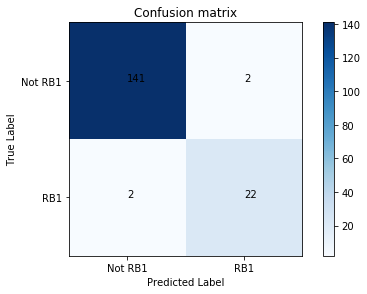

In [63]:
#Gets the most important features and make a new data frame
X_new=X.iloc[:,[18,19,24,25]]

#Split data set into training and test Sets
x_train_new,X_test_new,y_train_new,Y_test_new=train_test_split(X_new,Y, test_size=.3,random_state=42)
#Creates the Random Forest Classifier
rf_most_important=RandomForestClassifier(n_estimators=80, random_state=42)
#Fits tghe model
rf_most_important.fit(x_train_new,y_train_new)
#makes the prediction
prediction_new=rf_most_important.predict(X_test_new)
#Creates the confusion matrix
rf_new_cm=confusion_matrix(prediction_new,Y_test_new)
#plots the confusion matrix
plot_confusion_matrix(rf_new_cm,cm_plot_labels)

In [64]:
print('Precision Score for Random Forest is',precision_score(Y_test_new,prediction_new))
print('Recall Score for Random Forest is:',recall_score(Y_test_new,prediction_new))
print('Accuracy Socre Random Forest is :', accuracy_score(Y_test_new,prediction_new))

Precision Score for Random Forest is 0.9166666666666666
Recall Score for Random Forest is: 0.9166666666666666
Accuracy Socre Random Forest is : 0.9760479041916168


In [6]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [6]:
#Sets up Neural Network for model
rb_1_model=Sequential([Dense(14, activation='relu',input_dim=28),
    Dense(4,activation='relu'),
    Dense(2, activation='relu'),
    Dense(1,activation='sigmoid'),
])

In [7]:
#Compiles the model
rb_1_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=rb_1_model.fit(x_train,y_train,epochs=100,validation_data=(X_test, Y_test),verbose=0)



In [8]:
#Evaluates the model
rb_1_model.evaluate(x_train,y_train)

389/389 [==============================] - 0s 92us/step


[0.04033252310515369, 0.9845758080482483]

Confusion Matrix w/o Normalization
[[140   4]
 [  3  20]]


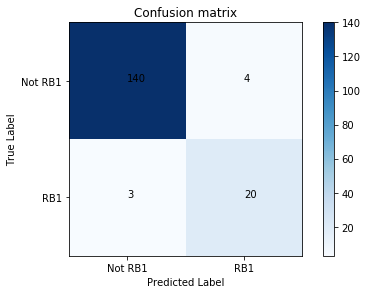

In [10]:
rb_prediction=rb_1_model.predict_classes(X_test)

rb_cm=confusion_matrix(rb_prediction,Y_test)

plot_confusion_matrix(rb_cm,cm_plot_labels)

In [11]:
print('Precision Score for Neural Network is',precision_score(Y_test,rb_prediction))
print('Recall Score for Neural Network is:',recall_score(Y_test,rb_prediction))
print('Accuracy Score Neural Network is:',accuracy_score(Y_test,rb_prediction))

Precision Score for Neural Network is 0.8695652173913043
Recall Score for Neural Network is: 0.8333333333333334
Accuracy Score Neural Network is: 0.9580838323353293


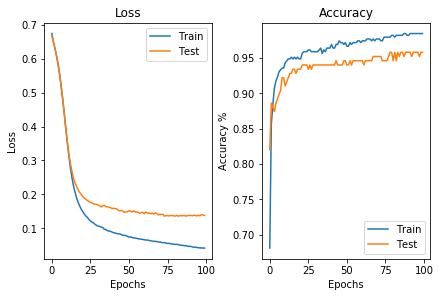

In [23]:
#Plots Accuracy and Loss train and validation data against Epochs
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper right')


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend(['Train','Test'],loc='lower right')
plt.tight_layout(pad=0.25)
plt.show()

In [6]:
#Creates the function to be able yo run Random Grid Search to find the best hyperparamters
def create_model(learning_rate=0.01,activation='relu'):
    model=Sequential()
    optimizer=Adam(lr=learning_rate)
    model.add(Dense(14,input_dim=28, activation=activation))
    model.add(Dense(4, activation=activation))
    model.add(Dense(2,activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [7]:
import random
#Keras Classifier
keras_reg=KerasClassifier(build_fn=create_model)
#Sets up parameter dictionary to test optimum hyperparametrs
params={
    'learning_rate':[.1,.01,.001],
    'epochs':[50,60,70,80,90,100]
}

random.seed(42)

#Random Search grid with 3 Kfolds-cross validation
rnd_search_cv=RandomizedSearchCV(keras_reg,param_distributions=params,cv=3)
#Fits the Random Search gird with train and test data
history=rnd_search_cv.fit(x_train,y_train,validation_data=(X_test,Y_test),verbose=0,callbacks=[EarlyStopping(monitor='val_accuracy',patience=10)])



129/129 [==============================] - 0s 206us/step


In [8]:
#Finds the best parameters to run the model through
rnd_search_cv.best_params_

{'learning_rate': 0.01, 'epochs': 100}

Confusion Matrix w/o Normalization
[[140   3]
 [  5  19]]


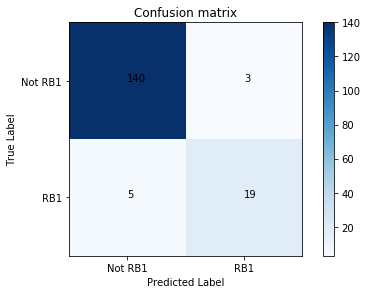

In [9]:
#Creates the model with the best hyperparameters
rb_1_model=rnd_search_cv.best_estimator_.model
#Creates the predictions
rb_1_predict=rb_1_model.predict_classes(X_test)
#Cretes the confusion matrix
rb_1_cm=confusion_matrix(Y_test,rb_1_predict)
#plots confusion matrix
plot_confusion_matrix(rb_1_cm,cm_plot_labels)


In [10]:
print('Precision Score for Neural Network is',precision_score(Y_test,rb_1_predict))
print('Recall Score for Neural Network is:',recall_score(Y_test,rb_1_predict))
print('Accuracy Score Neural Network is:',accuracy_score(Y_test,rb_1_predict))

Precision Score for Neural Network is 0.8636363636363636
Recall Score for Neural Network is: 0.7916666666666666
Accuracy Score Neural Network is: 0.9520958083832335


In [7]:
#creates 2nd Neural Network
model_2=Sequential([Dense(14, activation='relu',input_dim=28),
    Dense(4,activation='relu'),
    Dense(2, activation='relu'),
    Dense(1,activation='sigmoid'),
])

#Use Early Stopping to monitor validation accurarcy and stop the training once patience threshold has been met
model_2.compile(loss='binary_crossentropy',optimizer=Adam(lr=.001), metrics=['accuracy'])
history_2=model_2.fit(x_train,y_train,validation_data=(X_test, Y_test),verbose=0, epochs=100,
                     callbacks=[EarlyStopping(monitor='val_accuracy',patience=10)])

    

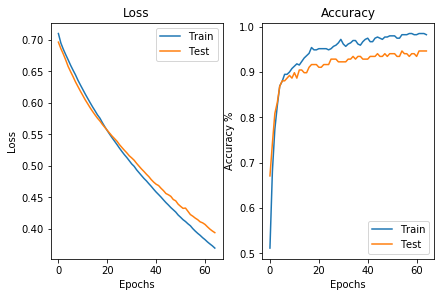

In [9]:
#Plots Accuracy and Loss for train and validation data sets
plt.subplot(1,2,1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title("Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper right')


plt.subplot(1,2,2)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend(['Train','Test'],loc='lower right')
plt.tight_layout(pad=0.25)
plt.show()

Confusion Matrix w/o Normalization
[[137   3]
 [  6  21]]


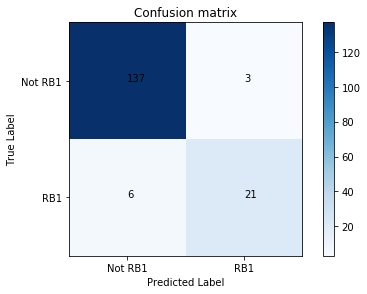

In [10]:
#Plots the confusion matrix
classes=model_2.predict_classes(X_test)

class_cm=confusion_matrix(classes,Y_test)

plot_confusion_matrix(class_cm, cm_plot_labels)

In [11]:
print('Precision Score for Neural Network is',precision_score(Y_test,classes))
print('Recall Score for Neural Network is:',recall_score(Y_test,classes))
print('Accuracy Score Neural Network is:',accuracy_score(Y_test,classes))

Precision Score for Neural Network is 0.7777777777777778
Recall Score for Neural Network is: 0.875
Accuracy Score Neural Network is: 0.9461077844311377


After running several different models through the Running back data, Random Forest did the best of the models in predicting whether a running back would finish as Running Back 1, i.e., finish top 12 in fantasy scoring. I was able to perform a feauture importance to extract the most important features for the Random Forest and was able to get the same results with just 4 variables as opposed to using all 28 variables.